In this notebook, we train and test a CNN network on MNIST data using PyTorch framework

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import timeit

In [2]:
dtype = torch.float
device=torch.device("cpu")

In [3]:
#load MNIST dataset

x_data=pd.read_csv("mnist.csv",delim_whitespace=True,header=None)
y_data=pd.read_csv("mnist-labels.csv",delim_whitespace=True,header=None)

train_end=int(x_data.shape[0]*0.5)
valid_end=int(train_end+(x_data.shape[0]*0.25))

#split into train,validation and test sets (50%,25%,25%)

x_train=x_data.iloc[0:train_end,:].values
y_train=y_data.iloc[0:train_end,:].values



x_valid=x_data.iloc[train_end:valid_end,:].values
y_valid=y_data.iloc[train_end:valid_end,:].values

x_test=x_data.iloc[valid_end:,:].values
y_test=y_data.iloc[valid_end:,:].values

In [7]:
#converting to torch format
x_train=torch.from_numpy(x_train)
x_train=x_train.float()
y_train=torch.from_numpy(y_train)
y_train=y_train.float()

x_valid=torch.from_numpy(x_valid)
x_valid=x_valid.float()
y_valid=torch.from_numpy(y_valid)
y_valid=y_valid.float()

x_test=torch.from_numpy(x_test)
x_test=x_test.float()
y_test=torch.from_numpy(y_test)
y_test=y_test.float()

In [8]:
x_train=x_train.view(-1,1,28,28)
x_valid=x_valid.view(-1,1,28,28)
x_test=x_test.view(-1,1,28,28)

Constructing our convolutional network with 2 conv layer, 2 pooling layers and an output fully connected layer

In [10]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,3,padding=1)
        self.pool1 = nn.MaxPool2d(2,stride=2)
        self.conv2 = nn.Conv2d(6,16,3,padding=1)
        self.pool2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = torch.nn.Linear(7*7*16,10)

    def forward(self, x):
        
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.softmax(self.fc1(x),dim=1)
        
        return x


A padding of 1 is chosen with a filter size of 3 to make the pooling layers only responsible for the subsampling of the image.

P=(F−1)/2 , where p=padding and F=filter size

In [11]:
def CrossEntropyLoss(o,y):
    
    eta=10**-10
    loss=-torch.sum(torch.mul(y,torch.log(eta+o)))/y.shape[0]
    
    return loss

In [12]:
def correct(o,y):
    
    c=(o.argmax(1)==y.argmax(1)).double().sum()
    return(c.item())

In [14]:
def shuffle(x,y):
    
    a=x.view(x.shape[0],-1)
    z=torch.cat((a,y),dim=1)
    z=z[torch.randperm(a.shape[0]),:]
    a=z[:,:z.shape[1]-y.shape[1]]
    y=z[:,z.shape[1]-y.shape[1]:]
    x=a.view(x.shape[0],x.shape[1],x.shape[2],x.shape[3])
    
    return [x,y]

In [17]:
def train_NN_MiniBatch(x_train,y_train,x_valid,y_valid,epochs,lr,batch_size,mom):
    
    loss_train=[]
    loss_valid=[]
    acc_train=[]
    acc_valid=[]
    batch_train=batch_size
    batch_valid=batch_size
    
    n_valid_batches=np.ceil(x_valid.shape[0]/batch_size)
    
    correct_train=0
    correct_valid=0
    
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=mom)
    
    p=0 #patience timer for early stopping
    
    for i in range(epochs):
        
        l_valid=0 #intialize epoch validation loss to zero
        
        for j in range(0,x_train.shape[0],batch_size):
            
            
            if (x_train.shape[0]-j< batch_size): #cater for the final batch size if #samples not divisible by batch size
                
                batch_train=x_train.shape[0]-j
                
            x_train_batch=x_train[j:j+batch_train,:,:,:]
            y_train_batch=y_train[j:j+batch_train,:]
            
            o_train_batch=model(x_train_batch)
            l_train=CrossEntropyLoss(o_train_batch,y_train_batch)
            correct_train+=correct(o_train_batch,y_train_batch)
            
            optimizer.zero_grad()
            l_train.backward()
            optimizer.step()
            
        for k in range(0,x_valid.shape[0],batch_size):
            
            if (x_valid.shape[0]-k< batch_size):#cater for the final batch size if #samples not divisible by batch size
                
                batch_valid=x_valid.shape[0]-k
                    
            x_valid_batch=x_valid[k:k+batch_valid,:,:,:]
            y_valid_batch=y_valid[k:k+batch_valid,:]
                    
            o_valid_batch=model(x_valid_batch)
            l_valid+=CrossEntropyLoss(o_valid_batch,y_valid_batch)
            correct_valid+=correct(o_valid_batch,y_valid_batch)
              
        l_valid/=n_valid_batches #consider the average validation loss overall batches
        
        batch_train=batch_size
        batch_valid=batch_size
        
        loss_train.append(l_train)
        loss_valid.append(l_valid)
        acc_train.append((correct_train*100.0)/x_train.shape[0])
        acc_valid.append((correct_valid*100.0)/x_valid.shape[0])
        
        correct_train=0
        correct_valid=0
        
        print("epoch",i+1)
        print("training loss",loss_train[i].item())
        print("validation loss",loss_valid[i].item())
        print("training accuracy",acc_train[i])
        print("validation accuracy",acc_valid[i])
        print('########################################################')
        
        if (i>0):
            if(loss_valid[i] >= loss_valid[i-1]):
                if(p==10):
                    break
                else:
                    p+=1
            else:
                p=0
            
        #shuffle data after each epoch to avoid having same batches
        
        x_train,y_train=shuffle(x_train,y_train)
        x_valid,y_valid=shuffle(x_valid,y_valid)
                
    return [acc_train,acc_valid,loss_train,loss_valid]

In [18]:
def test_MiniBatch(x_test,y_test,batch_size):
    
    batch_test=batch_size
    correct_test=0
    
    for i in range(0,x_test.shape[0],batch_size):
        
        if (x_test.shape[0]-i< batch_size):
            
            batch_test=x_test.shape[0]-i
                    
        x_test_batch=x_test[i:i+batch_test,:,:,:]
        y_test_batch=y_test[i:i+batch_test,:]
        
        o_test_batch=model(x_test_batch)
        correct_test+=correct(o_test_batch,y_test_batch)
        
    return (correct_test*100.0)/x_test.shape[0]

In [19]:
torch.manual_seed(1)
epochs=200
lr=0.1
batch_size=128
mom=0.5

model=ConvNet()

In [20]:
start_time=timeit.default_timer()
acc_train,acc_valid,loss_train,loss_valid=train_NN_MiniBatch(x_train,y_train,
                                                             x_valid,y_valid,epochs,lr,batch_size,mom)
elapsed_time=timeit.default_timer()-start_time
print("training time=",elapsed_time)

epoch 1
training loss 0.04637962952256203
validation loss 0.18714271485805511
training accuracy 84.56
validation accuracy 74.9
########################################################
epoch 2
training loss 0.04356582090258598
validation loss 0.3154463469982147
training accuracy 96.22666666666667
validation accuracy 95.71333333333334
########################################################
epoch 3
training loss 0.07054323703050613
validation loss 0.01927008293569088
training accuracy 97.19
validation accuracy 96.76666666666667
########################################################
epoch 4
training loss 0.02667125128209591
validation loss 0.019634271040558815
training accuracy 97.59333333333333
validation accuracy 97.17333333333333
########################################################
epoch 5
training loss 0.10852930694818497
validation loss 0.029674524441361427
training accuracy 97.82
validation accuracy 97.3
########################################################
epoch 6
training

epoch 42
training loss 0.0008717275341041386
validation loss 0.3377530574798584
training accuracy 99.84333333333333
validation accuracy 98.10666666666667
########################################################
epoch 43
training loss 0.0008820178918540478
validation loss 0.19723105430603027
training accuracy 99.78333333333333
validation accuracy 98.18666666666667
########################################################
epoch 44
training loss 0.006510432343930006
validation loss 0.24893033504486084
training accuracy 99.81666666666666
validation accuracy 98.26666666666667
########################################################
epoch 45
training loss 0.0034120017662644386
validation loss 0.0012613849248737097
training accuracy 99.88333333333334
validation accuracy 98.24666666666667
########################################################
epoch 46
training loss 0.0005130220088176429
validation loss 0.00014539230323862284
training accuracy 99.8
validation accuracy 98.16666666666667
#######

epoch 83
training loss 0.00010619778913678601
validation loss 0.00037595434696413577
training accuracy 100.0
validation accuracy 98.24666666666667
########################################################
epoch 84
training loss 1.0555015705904225e-07
validation loss 0.004795608576387167
training accuracy 100.0
validation accuracy 98.26
########################################################
epoch 85
training loss 0.0006975780124776065
validation loss 0.0010602085385471582
training accuracy 100.0
validation accuracy 98.26
########################################################
epoch 86
training loss 0.001386273535899818
validation loss 0.002935644006356597
training accuracy 100.0
validation accuracy 98.24666666666667
########################################################
epoch 87
training loss 5.690938633051701e-05
validation loss 0.0515146441757679
training accuracy 100.0
validation accuracy 98.22666666666667
########################################################
epoch 88
training

epoch 125
training loss 0.0002504572330508381
validation loss 3.9466478483518586e-05
training accuracy 100.0
validation accuracy 98.24666666666667
########################################################
epoch 126
training loss 1.0542640893618227e-06
validation loss 0.005237358156591654
training accuracy 100.0
validation accuracy 98.22666666666667
########################################################
epoch 127
training loss 0.00021958300203550607
validation loss 0.07130668312311172
training accuracy 100.0
validation accuracy 98.25333333333333
########################################################
epoch 128
training loss 0.00014914329221937805
validation loss 0.20966213941574097
training accuracy 100.0
validation accuracy 98.22666666666667
########################################################
epoch 129
training loss 2.8146125259809196e-05
validation loss 1.74626966327196e-05
training accuracy 100.0
validation accuracy 98.20666666666666
###########################################

epoch 167
training loss 6.27565459581092e-05
validation loss 0.00013884651707485318
training accuracy 100.0
validation accuracy 98.20666666666666
########################################################
epoch 168
training loss 1.6033813153626397e-05
validation loss 3.621087671490386e-06
training accuracy 100.0
validation accuracy 98.2
########################################################
epoch 169
training loss 0.00010603675036691129
validation loss 9.934108646802997e-09
training accuracy 100.0
validation accuracy 98.21333333333334
########################################################
epoch 170
training loss 5.776808029622771e-05
validation loss 0.103737473487854
training accuracy 100.0
validation accuracy 98.18666666666667
########################################################
epoch 171
training loss 1.707541014184244e-05
validation loss 3.00517581308668e-06
training accuracy 100.0
validation accuracy 98.21333333333334
########################################################
e

Text(0.5,1,'Training, validation accuracies')

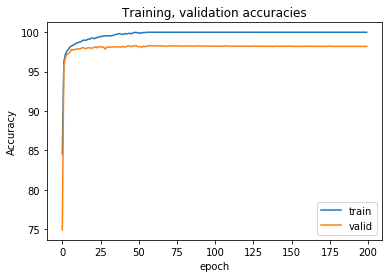

In [24]:
plt.plot(acc_train)
plt.plot(acc_valid)
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.title("Training, validation accuracies")

In [26]:
#test accuracy

test_acc=test_MiniBatch(x_test,y_test,batch_size=128)
print("Test accuracy=",test_acc)

Test accuracy= 98.26666666666667
